# Time Series Forecasting Model using Machine Learning ⏱
The purpose of this notebook is to create a Time_series Forecast Model which could predict the Pull/Call for the given dataset.



Since we already have a dataset, we'll approach the problem with the following machine learning modelling framework.
More specifically, we'll look at the following topics.

* **Exploratory data analysis (EDA)** - the process of going through a dataset and finding out more about it.
* **Model training** - create model(s) to learn to predict a target variable based on other variables.
* **Model evaluation** - evaluating a models predictions using problem-specific evaluation metrics. 
* **Cross-validation** - if we do build a good model, can we be sure it will work on unseen data?
* **Predicting the Test Data** - We now finally, predict the target using out trained model and the test data.
* **Plotting the Aquired Values** - We can visually validate the predicted values by seeing the trends on the plot

## 1. Importing required packages

In [2]:
# Regular EDA and plotting libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from yellowbrick.regressor import PredictionError
import datetime
from math import *

#To get rid of warnings
import warnings
warnings.filterwarnings("ignore")

# We want our plots to appear in the notebook
%matplotlib inline

## Models
from statsmodels.tsa.vector_ar.var_model import VAR

## Model evaluators
from sklearn.metrics import mean_squared_error

## 2. Data Exploration

Data can be found in `Data/` Folder. 
The ones we are going to use:
* `Test_dataset - Put-Call_TS.csv`


Once we have imported our data, we are going to explore and get to know about the different Attributes and their patterns with the data.

Data Exploration is one of most important tasks in Machine Learning.

We edited the given raw .xlsx file as it wasn't oraganized properly for `pandas` to read it.

Because of this issue the imported data would have `Object` as dtype instead `int64`.

**Note :** We havent manuplated data outside the notebook. You can cross verify with the .csv file

In [3]:
# Importing the Data
data = pd.read_csv("data/Test_dataset - Put-Call_TS.csv")

### 2.1 Minor Changes to the Index of the Data
There is a seperate column for `Stock Data` which is set as default index and the column is dropped.

In [4]:
data.index = data["Stock Index"] #Stock Index Column is set as default Index

data.drop('Stock Index',inplace=True, axis=1) 
# As this column is set as default index, we no lomger require this column
data

,10-Aug,11-Aug,12-Aug,13-Aug,14-Aug,15-Aug
Stock Index,,,,,,
AC3235,0.80,0.660,0.77240,0.983224,0.901211,0.898368
AC3236,0.86,0.732,0.85448,1.086645,1.017042,1.029258
AC3237,0.93,0.816,0.95024,1.207302,NaN,1.181962
AC3238,1.09,1.008,1.16912,1.483091,1.461062,1.531000
AC3239,NaN,1.104,1.27856,1.620986,1.615504,1.705519
...,...,...,...,...,...,...
AD2734,0.86,0.732,0.85448,1.086645,1.017042,1.029258
AD2735,0.64,0.468,0.55352,0.707435,0.592327,0.549330
AD2736,0.67,0.504,0.59456,0.759146,0.650243,0.614775


In [5]:
data.info() #Gives Insight about different Attributes

<class 'pandas.core.frame.DataFrame'>
Index: 3331 entries, AC3235 to AD2738
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   10-Aug  2902 non-null   float64
 1   11-Aug  3329 non-null   float64
 2   12-Aug  3274 non-null   float64
 3   13-Aug  3317 non-null   float64
 4   14-Aug  3226 non-null   float64
 5   15-Aug  3092 non-null   float64
dtypes: float64(6)
memory usage: 182.2+ KB


### 2.2 Filling Missing Values
Here we are using `pd.interpolate()` because that is optimal way of filling the missing values in a Time-Series DataSet. We could also fill with the `mean()` but in our case `pd.interpolate()` would work the best as the Columns and Rows are linearly depended too.


In [6]:
data.isna().sum() # Returns count of missing values

10-Aug    429
11-Aug      2
12-Aug     57
13-Aug     14
14-Aug    105
15-Aug    239
dtype: int64

In [7]:
data = data.interpolate() # To fill Missing Values

In [8]:
data.isna().sum() # All the missing are Handled

10-Aug    0
11-Aug    0
12-Aug    0
13-Aug    0
14-Aug    0
15-Aug    0
dtype: int64

In [9]:
data = data.T # Transposing the Data 
data

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
10-Aug,0.800000,0.860000,0.930000,1.090000,1.136667,1.183333,1.230000,1.000000,1.000000,1.070000,...,0.860000,0.600000,0.750000,0.990000,1.010000,0.860000,0.640000,0.670000,0.790000,0.740000
11-Aug,0.660000,0.732000,0.816000,1.008000,1.104000,1.152000,1.176000,0.900000,0.900000,0.984000,...,0.732000,0.420000,0.600000,0.888000,0.912000,0.732000,0.468000,0.504000,0.648000,0.588000
12-Aug,0.772400,0.854480,0.950240,1.169120,1.278560,1.333280,1.360640,1.046000,1.046000,1.066520,...,0.854480,0.498800,0.704000,1.032320,1.059680,0.854480,0.553520,0.594560,0.758720,0.690320
13-Aug,0.983224,1.086645,1.207302,1.483091,1.620986,1.689933,1.724406,1.327960,1.327960,1.448618,...,1.086645,0.638488,0.897040,1.310723,1.345197,1.086645,0.707435,0.759146,0.965987,0.879803
14-Aug,0.901211,1.017042,1.239052,1.461062,1.615504,1.692725,1.731335,1.287315,1.287315,1.316273,...,1.017042,0.515107,0.804685,1.268010,1.306620,1.017042,0.592327,0.650243,0.881906,0.785380
15-Aug,0.898368,1.029258,1.181962,1.531000,1.705519,1.792779,1.836409,1.334666,1.334666,1.487370,...,1.029258,0.462070,0.789294,1.312851,1.356481,1.029258,0.549330,0.614775,0.876553,0.767479


### 2.3 Parsing Indexes in DateTime Format
As this is Time-Series Problem its best to have `DateTime Object` as our indexes

In [10]:
data.index=pd.date_range("8/10/2020", freq="D", periods=6)
data

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-10,0.800000,0.860000,0.930000,1.090000,1.136667,1.183333,1.230000,1.000000,1.000000,1.070000,...,0.860000,0.600000,0.750000,0.990000,1.010000,0.860000,0.640000,0.670000,0.790000,0.740000
2020-08-11,0.660000,0.732000,0.816000,1.008000,1.104000,1.152000,1.176000,0.900000,0.900000,0.984000,...,0.732000,0.420000,0.600000,0.888000,0.912000,0.732000,0.468000,0.504000,0.648000,0.588000
2020-08-12,0.772400,0.854480,0.950240,1.169120,1.278560,1.333280,1.360640,1.046000,1.046000,1.066520,...,0.854480,0.498800,0.704000,1.032320,1.059680,0.854480,0.553520,0.594560,0.758720,0.690320
2020-08-13,0.983224,1.086645,1.207302,1.483091,1.620986,1.689933,1.724406,1.327960,1.327960,1.448618,...,1.086645,0.638488,0.897040,1.310723,1.345197,1.086645,0.707435,0.759146,0.965987,0.879803
2020-08-14,0.901211,1.017042,1.239052,1.461062,1.615504,1.692725,1.731335,1.287315,1.287315,1.316273,...,1.017042,0.515107,0.804685,1.268010,1.306620,1.017042,0.592327,0.650243,0.881906,0.785380
2020-08-15,0.898368,1.029258,1.181962,1.531000,1.705519,1.792779,1.836409,1.334666,1.334666,1.487370,...,1.029258,0.462070,0.789294,1.312851,1.356481,1.029258,0.549330,0.614775,0.876553,0.767479


### 2.4 Splitting the Data
The Data should be splitted into **train** and **test** .

* **Train** Data is used to train the model.

* **Test** Data is used to evaluate the model.

In [11]:
train = data[:int(0.9*(len(data)))]
valid = data[int(0.9*(len(data))):]

In [12]:
train #Data from Aug 10th to Aug 14th

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-10,0.800000,0.860000,0.930000,1.090000,1.136667,1.183333,1.230000,1.000000,1.000000,1.070000,...,0.860000,0.600000,0.750000,0.990000,1.010000,0.860000,0.640000,0.670000,0.790000,0.740000
2020-08-11,0.660000,0.732000,0.816000,1.008000,1.104000,1.152000,1.176000,0.900000,0.900000,0.984000,...,0.732000,0.420000,0.600000,0.888000,0.912000,0.732000,0.468000,0.504000,0.648000,0.588000
2020-08-12,0.772400,0.854480,0.950240,1.169120,1.278560,1.333280,1.360640,1.046000,1.046000,1.066520,...,0.854480,0.498800,0.704000,1.032320,1.059680,0.854480,0.553520,0.594560,0.758720,0.690320
2020-08-13,0.983224,1.086645,1.207302,1.483091,1.620986,1.689933,1.724406,1.327960,1.327960,1.448618,...,1.086645,0.638488,0.897040,1.310723,1.345197,1.086645,0.707435,0.759146,0.965987,0.879803
2020-08-14,0.901211,1.017042,1.239052,1.461062,1.615504,1.692725,1.731335,1.287315,1.287315,1.316273,...,1.017042,0.515107,0.804685,1.268010,1.306620,1.017042,0.592327,0.650243,0.881906,0.785380


In [13]:
valid #Data on Aug 15th

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-15,0.898368,1.029258,1.181962,1.531,1.705519,1.792779,1.836409,1.334666,1.334666,1.48737,...,1.029258,0.46207,0.789294,1.312851,1.356481,1.029258,0.54933,0.614775,0.876553,0.767479


## 3. Training Our Model
We've explored the data, now we'll try to use machine learning to predict our target variable

Best Algorithm for this problem is : **VAR** : Vector Autoregression is most commonly used methods for multivariate time series forecasting.



In [18]:
# Training our model using Trained Data
model = VAR(endog=train)
model_fit = model.fit()
model_fit

In [19]:
cols = data.columns

prediction = model_fit.forecast(model_fit.endog, steps=len(valid))
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])

# For loop to append all the predictions to a DataFrame : pred
for j in range(0,3331):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

In [20]:
pred.index = [datetime.datetime(2020, 8, 15)]
pred.T #These are the values predicted by the for August 15th

,2020-08-15
Stock Index,
AC3235,1.01983
AC3236,1.138537
AC3237,1.323383
AC3238,1.593582
AC3239,1.751858
...,...
AD2734,1.138537
AD2735,0.703277
AD2736,0.76263


## 4. Model Evaluation
Our model has just predicted the values for August 15th. We will be comparing these value with valid values. 

### Root Mean Square Error
The **root-mean-square error (RMSE)** is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed.

The below for loop will output RMSE Value for each Stock. And all the values are nearer to zero as they should be.

In [21]:
# The below for loop will output RMSE Value for each Stock(3331 Stocks). 
# And all the values are nearer to zero as they should be.

for i in cols:
    print('RMSE Value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])))

RMSE Value for AC3235 is :  0.12146140913346892
RMSE Value for AC3236 is :  0.10927940928598989
RMSE Value for AC3237 is :  0.1414206257288304
RMSE Value for AC3238 is :  0.06258174503735137
RMSE Value for AC3239 is :  0.046339079907384395
RMSE Value for AC3240 is :  0.038217746342409153
RMSE Value for AC3241 is :  0.034157080059920686
RMSE Value for AC3242 is :  0.08085474430856654
RMSE Value for AC3243 is :  0.08085474430856654
RMSE Value for AC3244 is :  0.05532088785756062
RMSE Value for AC3245 is :  0.07476374488482129
RMSE Value for AC3246 is :  0.10521874300350276
RMSE Value for AC3247 is :  0.13973440740467324
RMSE Value for AC3248 is :  0.16343189356205245
RMSE Value for AC3249 is :  0.16700768016669043
RMSE Value for AC3250 is :  0.1580074066758803
RMSE Value for AC3251 is :  0.14582540782841202
RMSE Value for AC3252 is :  0.06258174503735137
RMSE Value for AC3253 is :  0.1559770735346372
RMSE Value for AC3254 is :  0.07679407802606764
RMSE Value for AC3255 is :  0.0585210787

## 5. Predicting Pull-Call Value on August 16th

Now we are feeding our model complete data (from 10th Aug to 15th Aug) and it's gonna output or predictions for 16Th August

In [22]:
model = VAR(endog=data)
model_fit = model.fit()
aug16 = model_fit.forecast(model_fit.endog, steps=1)
aug16

array([[1.09334771, 1.21766081, 1.35187101, ..., 0.82400267, 1.07262886,
        0.96903462]])

In [43]:
# Converting the ARRAY into DataFrame and setting indexes and columns

aug16 = pd.DataFrame(aug16,index=[datetime.datetime(2020, 8, 16)],columns = valid.columns)
aug16
aug16.shape

(1, 3331)

In [54]:
#Appending the 16th August Prediction to initial Dataset so that we aquire complete Time-Series DataSet

complete_data = data._append(aug16,ignore_index=False)
data

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-10,0.800000,0.860000,0.930000,1.090000,1.136667,1.183333,1.230000,1.000000,1.000000,1.070000,...,0.860000,0.600000,0.750000,0.990000,1.010000,0.860000,0.640000,0.670000,0.790000,0.740000
2020-08-11,0.660000,0.732000,0.816000,1.008000,1.104000,1.152000,1.176000,0.900000,0.900000,0.984000,...,0.732000,0.420000,0.600000,0.888000,0.912000,0.732000,0.468000,0.504000,0.648000,0.588000
2020-08-12,0.772400,0.854480,0.950240,1.169120,1.278560,1.333280,1.360640,1.046000,1.046000,1.066520,...,0.854480,0.498800,0.704000,1.032320,1.059680,0.854480,0.553520,0.594560,0.758720,0.690320
2020-08-13,0.983224,1.086645,1.207302,1.483091,1.620986,1.689933,1.724406,1.327960,1.327960,1.448618,...,1.086645,0.638488,0.897040,1.310723,1.345197,1.086645,0.707435,0.759146,0.965987,0.879803
2020-08-14,0.901211,1.017042,1.239052,1.461062,1.615504,1.692725,1.731335,1.287315,1.287315,1.316273,...,1.017042,0.515107,0.804685,1.268010,1.306620,1.017042,0.592327,0.650243,0.881906,0.785380
2020-08-15,0.898368,1.029258,1.181962,1.531000,1.705519,1.792779,1.836409,1.334666,1.334666,1.487370,...,1.029258,0.462070,0.789294,1.312851,1.356481,1.029258,0.549330,0.614775,0.876553,0.767479


In [55]:
complete_data

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-10,0.800000,0.860000,0.930000,1.090000,1.136667,1.183333,1.230000,1.000000,1.000000,1.070000,...,0.860000,0.600000,0.750000,0.990000,1.010000,0.860000,0.640000,0.670000,0.790000,0.740000
2020-08-11,0.660000,0.732000,0.816000,1.008000,1.104000,1.152000,1.176000,0.900000,0.900000,0.984000,...,0.732000,0.420000,0.600000,0.888000,0.912000,0.732000,0.468000,0.504000,0.648000,0.588000
2020-08-12,0.772400,0.854480,0.950240,1.169120,1.278560,1.333280,1.360640,1.046000,1.046000,1.066520,...,0.854480,0.498800,0.704000,1.032320,1.059680,0.854480,0.553520,0.594560,0.758720,0.690320
2020-08-13,0.983224,1.086645,1.207302,1.483091,1.620986,1.689933,1.724406,1.327960,1.327960,1.448618,...,1.086645,0.638488,0.897040,1.310723,1.345197,1.086645,0.707435,0.759146,0.965987,0.879803
2020-08-14,0.901211,1.017042,1.239052,1.461062,1.615504,1.692725,1.731335,1.287315,1.287315,1.316273,...,1.017042,0.515107,0.804685,1.268010,1.306620,1.017042,0.592327,0.650243,0.881906,0.785380
2020-08-15,0.898368,1.029258,1.181962,1.531000,1.705519,1.792779,1.836409,1.334666,1.334666,1.487370,...,1.029258,0.462070,0.789294,1.312851,1.356481,1.029258,0.549330,0.614775,0.876553,0.767479
2020-08-16,1.093348,1.217661,1.351871,1.694194,1.859945,1.942821,1.984258,1.507725,1.507725,1.561530,...,1.217661,0.678971,0.989753,1.487006,1.528444,1.217661,0.761846,0.824003,1.072629,0.969035


## 6. Plotting the Predicted Values
Below is the plot for 12 Stocks as plotting all 3331 stocks would be time/power consuming

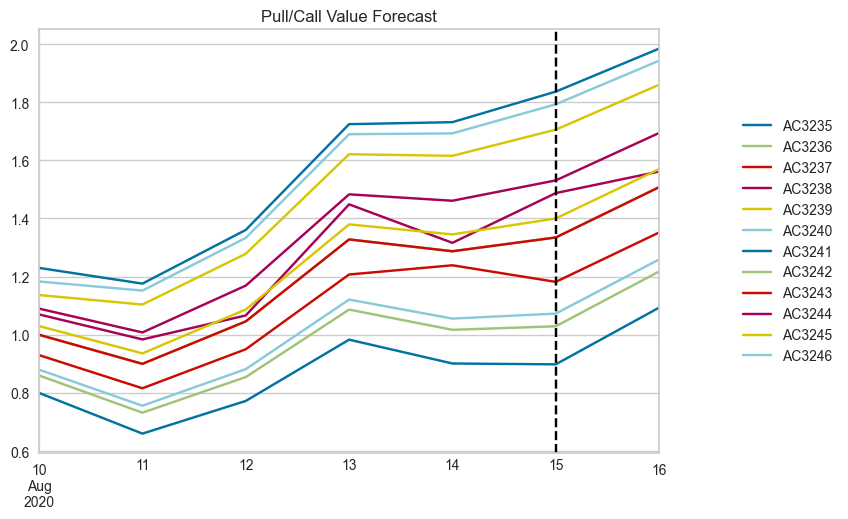

In [56]:
pt = complete_data.iloc[:,:12].plot()
plt.title("Pull/Call Value Forecast")
plt.legend(loc=5,bbox_to_anchor=(1.3, 0.5))
plt.axvline(datetime.datetime(2020, 8, 15),linestyle='--',color='black');

The values right to the dotted lines are predicted by the model i.e. "16th Aug" Values.

In [58]:
aug16.to_csv("Answer_files/file_02.csv",index=True)
#Finally The predicted values are exported as .csv file
aug16

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-16,1.093348,1.217661,1.351871,1.694194,1.859945,1.942821,1.984258,1.507725,1.507725,1.56153,...,1.217661,0.678971,0.989753,1.487006,1.528444,1.217661,0.761846,0.824003,1.072629,0.969035
